The following code reproduces Figure 1 from the manuscript, containing the following: 

The Southern Ocean SST step response to perturbations from broad-scale surface freshening (faf-water experiments; a-c) and Antarctic meltwater (antwater experiments; d-f). (a,d) shows the annually averaged spatial pattern of freshwater perturbations for each experiment ($F_{step}$); the green circle in (a) denotes the spatial integral domain for calculating $F_{step-fw}$ (90$^{\circ}$S - 50$^{\circ}$S).(b,e) shows the spatial pattern of the multi-model mean SST step response ($\overline{\Delta SST}$) averaged over years 60-70 for each experiment; green circles in (b,e) denote the Southern Ocean region (65$^{\circ}$S - 50$^{\circ}$S). (c,f) shows the Southern Ocean-averaged response for each model (thin grey lines) and the multi-model mean (black line) as a function of time, overlaid with corresponding climate response functions (CRFs, blue lines); vertical dashed lines in (c,f) denote year 70, when faf-water experiments end. SST step responses (b,c,e,f) are scaled per 3,000 Gt yr$^{-1}$ forcing for equal comparison.

In [ ]:
import os
import numpy as np
import xarray as xr
import gsw
import netCDF4

from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.stats import linregress

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Set root directory (replace with local path of your repo) 
root_dir = "/Users/zackkaufman/Documents/Repos/Kaufman_Freshwater_Analysis"

In [5]:
# import/calculate faf-water forcing field and its magnitude 

data_path = os.path.join(root_dir,"Source_Data/MIP_forcing_fields")
os.chdir(data_path) 

fafwater_forcing = xr.open_dataset('wfo_input4MIPs_surfaceFluxes_FAFMIP_NCAS-2-1-0_gn.nc')

# get spatial subset of time-mean faf-water forcing for computing integrated 90S-50S freshwater flux 

fafwater_forcing_subset = fafwater_forcing.sel(latitude=slice(-90,-50)).mean(dim='time')

########################################################################
# since fafwater_forcing grid doesn't have areacello, we compute it explicity using gsw.distance 
########################################################################

# initialize empty arrays to compute grid cell area 

lat_distances = np.zeros((len(fafwater_forcing_subset.latitude),len(fafwater_forcing_subset.longitude)))
lon_distances = np.zeros((len(fafwater_forcing_subset.latitude),len(fafwater_forcing_subset.longitude)))

# get midpoint and edge coordinates 

lat_midpoints = fafwater_forcing_subset.latitude
lon_midpoints = fafwater_forcing_subset.longitude

lat_edges = fafwater_forcing_subset.bound_latitude
lon_edges = fafwater_forcing_subset.bound_longitude 

# compute distances in each dimension. lon_distances converge towards pole, lat_distances are constant. 

for lat in range(len(lat_distances[:,0])):
    for lon in range(len(lon_distances[0,:])):
        
        lat_distances[lat,lon] = gsw.distance\
        ([lon_midpoints[lon],lon_midpoints[lon]],[lat_edges[lat,0],lat_edges[lat,1]])
        
        lon_distances[lat,lon] = gsw.distance\
        ([lon_edges[lon,0],lon_edges[lon,1]],[lat_midpoints[lat],lat_midpoints[lat]])       


areacello_subset_explicit = lat_distances*lon_distances

########################################################################

unit_conversion = (1e-12)*(3.154*1e7) #kg/s to Gt/yr 

F_step_fw = (fafwater_forcing_subset.wfo * areacello_subset_explicit)\
.sum(dim=('longitude','latitude'),skipna=True) * unit_conversion

print('F_step_fw in Gt/yr (90S to 50s) = ', F_step_fw.values)

# save annual mean fafwater_forcing_map for future plotting in Fig. 1a 

fafwater_forcing_map = fafwater_forcing.wfo.mean(dim='time')


F_step_fw in Gt/yr (90S to 50s) =  3956.883981293495


In [6]:
# import/calculate antwater forcing field and its magnitude 
# We don't need to do a spatial integral or time average since forcing is only applied near Antarctica 

antwater_forcing = xr.open_dataset('ocean_time_constant.prcme_adj.nc')
antwater_forcing_map = antwater_forcing.prcme_adj

# antwater forcing magnitude in Gt/yr is published in Swart et al. 2023 as .1 Sv = 3154 Gt/yr
F_step_aw = 3154

In [7]:
# import maps of SST response to antwater and faf-water forcing (averaged experiment years 60-70)
# pre-processed data on standard 1x1 grid. 

# Path to files
data_path = os.path.join(root_dir,"Source_Data/SST_step_responses")
os.chdir(data_path)

SST_anoms_antwater = xr.open_dataset('SST_response_maps_antwater.nc').thetao
SST_anoms_fafwater = xr.open_dataset('SST_response_maps_fafwater.nc').__xarray_dataarray_variable__

# for scaling responses by 3000 Gt/yr forcing
scale_factor_fafwater = (3000/F_step_fw.values)
scale_factor_antwater = (3000/F_step_aw)

In [8]:
########################################################################
def subset_bylatitude(data, south_bound, north_bound):
    lat_mask = (data.lat >= south_bound) & (data.lat <= north_bound)
    data_SO = data.where(lat_mask, drop=True)
    return data_SO
########################################################################

# spatially average CMIP6 Omon field over specified latitudes
# assumes spatial average is conducted over all longitudes
# Assumes preprocessed grid conventions 
def spatial_average(inputdata,southlat,northlat):
    data_subset = subset_bylatitude\
    (inputdata,south_bound=southlat,north_bound=northlat)
    lat_subset = data_subset.lat
    coslat = np.cos(np.deg2rad(lat_subset))
    weight_factor = coslat / coslat.mean(dim='y')
    data_average = \
    (data_subset * weight_factor).mean(dim=('x', 'y'),skipna=True)
    return data_average
########################################################################

# get multi-model mean and intermodel spread in SST responses 

antwater_response_patterns_spatialavg = spatial_average(SST_anoms_antwater,-65,-50)*scale_factor_antwater

fafwater_response_patterns_spatialavg = spatial_average(SST_anoms_fafwater,-65,-50)*scale_factor_fafwater

print('Antwater mean and stdev:')
print(antwater_response_patterns_spatialavg.mean(dim='model').values,\
      antwater_response_patterns_spatialavg.std(dim='model').values)
print('Fafwater mean and stdev:')
print(fafwater_response_patterns_spatialavg.mean(dim='model').values,\
      fafwater_response_patterns_spatialavg.std(dim='model').values)

Antwater mean and stdev:
-0.7059049404831038 0.2675097368261531
Fafwater mean and stdev:
-0.3355280889479209 0.2274332375949655


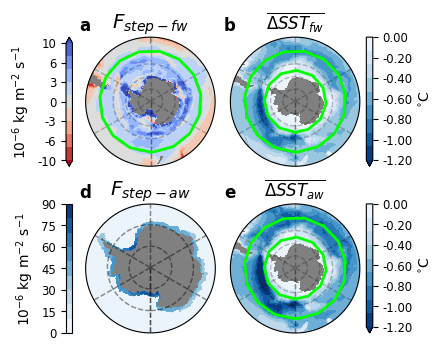

CPU times: user 18.6 s, sys: 241 ms, total: 18.9 s
Wall time: 20.3 s


In [9]:
%%time 

# Plot Fig. 1a,d,b,e

# get multi-model mean responses (scaled)
SST_anoms_antwater_mean = SST_anoms_antwater.mean(dim='model')*scale_factor_antwater
SST_anoms_fafwater_mean = SST_anoms_antwater.mean(dim='model')*scale_factor_fafwater

########################################################################

# define parameters for each map subplot
cbarmin_plot1 = -10
cbarmax_plot1 = 10
cbarlabel_plot1 = r'$10^{-6}$ kg m$^{-2}$ s$^{-1}$'
cmap_plot1 = 'coolwarm_r'  
levels_plot1 = np.linspace(cbarmin_plot1, cbarmax_plot1, 10)
ticks_plot1 = np.linspace(cbarmin_plot1, cbarmax_plot1, 7)

cbarmin_plot2 = 0
cbarmax_plot2 = 90
cbarlabel_plot2 = r'$10^{-6}$ kg m$^{-2}$ s$^{-1}$'
cmap_plot2 = 'Blues'  
levels_plot2 = np.linspace(cbarmin_plot2, cbarmax_plot2, 10)
ticks_plot2 = np.linspace(cbarmin_plot2, cbarmax_plot2, 7)

cbarmin_plot3 =  -1.2
cbarmax_plot3 = 0
levels_plot3 = np.linspace(cbarmin_plot3, cbarmax_plot3, 10)
ticks_plot3 = np.linspace(cbarmin_plot3, cbarmax_plot3, 7)

cbarmin_plot4 =  -1.2
cbarmax_plot4 = 0
levels_plot4 = np.linspace(cbarmin_plot4, cbarmax_plot4, 10)
ticks_plot4 = np.linspace(cbarmin_plot4, cbarmax_plot4, 7)

cbarlabel_plot3_4 = r'$^{\circ}$C'
cmap_plot3_4 = 'Blues_r'  

########################################################################

# define plot 
fig, axs = plt.subplots(2, 2, figsize=(4.32, 5.5),
                        subplot_kw=dict(projection=ccrs.SouthPolarStereo()),
                        layout='compressed')

########################################################################

# Iterate over each row in the grid
for row in axs:
    # Iterate over each axis in the row
    for ax in row:
        ax.set_facecolor('gray')
        # Set basemap parameters for the current axis
        ax.set_extent([-180, 180, -89, -40], ccrs.PlateCarree())


        # Add latitude circles in 10-degree intervals
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                          linewidth=1, color='black', linestyle='--',zorder=200,alpha=.25)
        gl.ylocator = mticker.FixedLocator(np.arange(-90, -19, 10))

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)

# however, we want to zoom in for antwater forcing 
axs[1,0].set_extent([-180, 180, -89, -60], ccrs.PlateCarree())

# Add latitude circles in 10-degree intervals for antwater
gl = axs[1,0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='black', linestyle='--',zorder=200,alpha=.25)
gl.ylocator = mticker.FixedLocator(np.arange(-90, -19, 10))

########################################################################

# Plot the data
forcing_plot1 = \
axs[0,0].contourf(fafwater_forcing_map.longitude, fafwater_forcing_map.latitude, fafwater_forcing_map*1e6,
                       transform=ccrs.PlateCarree(), levels=levels_plot1, cmap=cmap_plot1, extend='both')

forcing_plot2 = \
axs[1,0].contourf(antwater_forcing_map.x, antwater_forcing_map.y, \
                  antwater_forcing_map*1e6,transform=ccrs.PlateCarree(), \
                  levels=levels_plot2,cmap=cmap_plot2)

response_plot3 = \
axs[0,1].contourf(SST_anoms_fafwater.lon, SST_anoms_fafwater.lat, SST_anoms_fafwater_mean,
                       transform=ccrs.PlateCarree(), levels=levels_plot3, cmap=cmap_plot3_4, extend='min')

response_plot4 = \
axs[1,1].contourf(SST_anoms_antwater.x, SST_anoms_antwater.y, SST_anoms_antwater_mean,
                       transform=ccrs.PlateCarree(), levels=levels_plot4, cmap=cmap_plot3_4, extend='min')

########################################################################

# add averaging boundaries 
axs[0,0].plot([-180, 180], [-50, -50], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)

axs[0,1].plot([-180, 180], [-50, -50], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)
axs[0,1].plot([-180, 180], [-65, -65], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)

axs[1,1].plot([-180, 180], [-50, -50], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)
axs[1,1].plot([-180, 180], [-65, -65], transform=ccrs.PlateCarree(), color='lime', linewidth=2,zorder=300)

########################################################################

# create titles for each subplot
for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        if i == 0 and j == 0:
            ax.set_title(r'$F_{step-fw}$', fontsize='x-large')
            ax.text(-0.05, 1.05, "a", transform=ax.transAxes, fontsize='large', fontweight='bold')
        elif i == 1 and j == 0:
            ax.set_title(r'$F_{step-aw}$', fontsize='x-large')
            ax.text(-0.05, 1.05, "d", transform=ax.transAxes, fontsize='large', fontweight='bold')
        elif i == 0 and j == 1:
            ax.set_title(r'$\overline{\Delta SST_{fw}}$')
            ax.text(-0.05, 1.05, "b", transform=ax.transAxes, fontsize='large', fontweight='bold')
        elif i == 1 and j == 1:
            ax.set_title(r'$\overline{\Delta SST_{aw}}$')
            ax.text(-0.05, 1.05, "e", transform=ax.transAxes, fontsize='large', fontweight='bold')       

########################################################################

# Create colorbars for each subplot
cbar1 = fig.colorbar(forcing_plot1, ax=axs[0,0],ticks=ticks_plot1, location='left', format="%d")
cbar1.ax.tick_params(labelsize='small')
cbar1.set_label(cbarlabel_plot1)

cbar2 = fig.colorbar(forcing_plot2, ax=axs[1,0], ticks=ticks_plot2, location='left', format="%d")
cbar2.ax.tick_params(labelsize='small')
cbar2.set_label(cbarlabel_plot2)

cbar3 = fig.colorbar(response_plot3, ax=axs[0,1],ticks=ticks_plot3, location='right', format='%.2f')
cbar3.ax.tick_params(labelsize='small')
cbar3.set_label(cbarlabel_plot3_4)

cbar4 = fig.colorbar(response_plot4, ax=axs[1,1],ticks=ticks_plot4, location='right', format='%.2f')
cbar4.ax.tick_params(labelsize='small')
cbar4.set_label(cbarlabel_plot3_4)

########################################################################

# show the plot 
plt.show()

In [10]:
# import spatially averaged SST response time series (experiment minus time average piControl)
# data is annually averaged, length varies among models. 

########################################################################

def list_nc_groups(filename):
    # Open the NetCDF file
    with netCDF4.Dataset(filename, "r") as nc:
        # Get all group names
        groups = list(nc.groups.keys())
    return groups

########################################################################

groups_antwater = list_nc_groups('antwater_CRFs_unscaled.nc')
groups_fafwater = list_nc_groups('fafwater_CRFs_unscaled.nc')

CRFs_antwater_raw = {}
CRFs_fafwater_raw = {}

for group in groups_antwater: 
    CRFs_antwater_raw[group] = xr.open_dataset('antwater_CRFs_unscaled.nc',group=group)\
    .__xarray_dataarray_variable__.values * scale_factor_antwater

for group in groups_fafwater: 
    CRFs_fafwater_raw[group] = xr.open_dataset('fafwater_CRFs_unscaled.nc',group=group)\
    .__xarray_dataarray_variable__.values * scale_factor_fafwater


In [11]:

# calculate climate response function fits and their parameters 

########################################################################

def func(x, a, b):
    return a * (1 - np.exp(-x / b))

def exponential_fit(x, y):
    if np.isnan(y).any():
        y = np.where(y > 1e100, y, np.nan)
        return y, np.nan, np.nan
    popt, pcov = curve_fit(func, x, y)
    curve = func(x, *popt)
    # Calculate standard errors
    perr = np.sqrt(np.diag(pcov))
    return curve, popt[0], popt[1], perr[0], perr[1]

########################################################################

# Create new dictionaries for best fit lines, fit parameters, and standard errors
fafwater_response_fit_dict = {}
antwater_response_fit_dict = {}
fit_parameters_fafwater = {}
fit_parameters_antwater = {}
standard_errors_fafwater = {}
standard_errors_antwater = {}

# Populate the dictionaries with best fit lines, fit parameters, and standard errors
for key, y_values in CRFs_fafwater_raw.items():
    fit_line, a, b, std_err_a, std_err_b = \
    exponential_fit(np.linspace(0, len(y_values) - 1, len(y_values)), y_values)
    fafwater_response_fit_dict[key + '_fit'] = fit_line
    fit_parameters_fafwater[key] = {'a': a, 'b': b}
    standard_errors_fafwater[key] = {'a': std_err_a, 'b': std_err_b}

for key, y_values in CRFs_antwater_raw.items():
    fit_line, a, b, std_err_a, std_err_b = \
    exponential_fit(np.linspace(0, len(y_values) - 1, len(y_values)), y_values)
    antwater_response_fit_dict[key + '_fit'] = fit_line
    fit_parameters_antwater[key] = {'a': a, 'b': b}
    standard_errors_antwater[key] = {'a': std_err_a, 'b': std_err_b}


In [12]:
# get multi-model mean CRFs and their fits in the years where all models align (70 for fafwater,100 for antwater). 

fafwater_CRF_list = []
antwater_CRF_list = []
fafwater_fit_list = []
antwater_fit_list = []

for array in CRFs_fafwater_raw.values():
    fafwater_CRF_list.append(array[:70])
for array in fafwater_response_fit_dict.values():
    fafwater_fit_list.append(array[:70])
for array in CRFs_antwater_raw.values():
    antwater_CRF_list.append(array[:100])
for array in antwater_response_fit_dict.values():
    antwater_fit_list.append(array[:100])

stack = np.stack(fafwater_CRF_list, axis=0)
fafwater_CRF_timemean = np.mean(stack, axis=0)

stack = np.stack(antwater_CRF_list, axis=0)
antwater_CRF_timemean = np.mean(stack, axis=0)

stack = np.stack(fafwater_fit_list, axis=0)
fafwater_fit_timemean = np.mean(stack, axis=0)

stack = np.stack(antwater_fit_list, axis=0)
antwater_fit_timemean = np.mean(stack, axis=0)


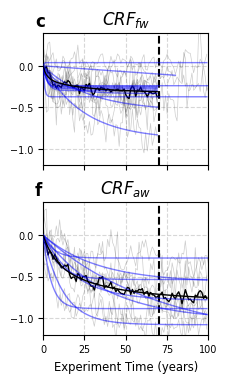

In [13]:
# Plot Fig. 1c,f 

########################################################################

# Function to plot time series and their averages
def plot_time_series(ax, time_series_dict, fit_dict, time_mean, fit_mean, title):

    # Plot individual time series with thin black lines
    for array in time_series_dict.values():
        ax.plot(array, color='black', alpha=0.2, linestyle='-', linewidth=0.5)
    
    # Plot individual time series fits with thin blue lines 
    for array in fit_dict.values():
        ax.plot(array, color='blue', alpha=.5, linestyle='-', linewidth=1,zorder=200)
    
    # Plot average with thicker lines 
    ax.plot(fit_mean, color='black', linestyle='-', linewidth=1,zorder=200)
    ax.plot(time_mean, color='black', linestyle='-', linewidth=1)
    
    # Set title
    ax.set_title(title)

########################################################################


# Create subplots with shared x-axis
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(2.16,3.72),sharex=True,sharey=True,layout='compressed')

# Plot for fafwater_response_dict
plot_time_series(axs[0],\
        CRFs_fafwater_raw, fafwater_response_fit_dict,fafwater_CRF_timemean,fafwater_fit_timemean, r'$CRF_{fw}$')
axs[0].set_xlim(0,100)
axs[0].set_ylim(-1.2,.4)
axs[0].axvline(70,color='k',linestyle='dashed')
axs[0].tick_params(labelsize='x-small')


# Plot for antwater_response_dict
plot_time_series(axs[1], \
    CRFs_antwater_raw, antwater_response_fit_dict,antwater_CRF_timemean,antwater_fit_timemean, r'$CRF_{aw}$')
axs[1].set_xlabel('Experiment Time (years)',fontsize='small')
axs[1].set_xlim(0,100)
axs[1].set_ylim(-1.2,.4)
axs[1].axvline(70,color='k',linestyle='dashed')
axs[1].tick_params(labelsize='x-small')

########################################################################

# Set x ticks in intervals of 25 from 0 to 100
for ax in axs:
    ax.set_xticks(np.arange(0, 101, 25))

# Add grid lines
for ax in axs:
    ax.grid(True, linestyle='--', alpha=0.5)

########################################################################

# create titles for each subplot
for i,ax in enumerate(axs):
    if i == 0:
        ax.text(-0.05, 1.05, "c", transform=ax.transAxes, fontsize='large', fontweight='bold')
    else:
        ax.text(-0.05, 1.05, "f", transform=ax.transAxes, fontsize='large', fontweight='bold')

########################################################################

# Show the plot
plt.show()